In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import scrublet as scr
import anndata
import scanpy.external as sce
import scvelo as scv
#import scrublet as scr # requires 'pip install scrublet'
import os
import sklearn
import bbknn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import seaborn as sbn #nicer plots
np.random.seed(0)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100,dpi_save=800)  # low dpi (dots per inch) yields small inline figures

ImportError: Matplotlib requires numpy>=1.20; you have 1.19.2

In [2]:
adata =sc.read_h5ad('./cache/sc_QC.h5ad')

In [2]:
adata =sc.read_h5ad('./step7-scRNA/sc.h5ad')

In [3]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
A2_L1_P049                2435      270057.0          39190.0      14.511750   
A3_L1_P049                 535      102903.0           4517.0       4.389571   
A4_L1_P049                 495       83074.0           2775.0       3.340395   
A5_L1_P049                 769      154154.0           7935.0       5.147450   
A6_L1_P049                 708      110428.0          11488.0      10.403158   
...                        ...           ...              ...            ...   
P13_L4_P401                920       76541.0          23363.0      30.523508   
P14_L4_P401               2622      356660.0          36594.0      10.260192   
P15_L4_P401               3173      356350.0          51275.0      14.388943   
P21_L4_P401               2537      467461.0          43998.0       9.412122   
P22_L4_P401               2453      419922.0          36324.0       8.650178   

             total_counts_ribo  pct_counts_ribo  total_counts_hb  \
A2_L1_P049              2642.0         0.978312            939.0   
A3_L1_P049              1990.0         1.933860              1.0   
A4_L1_P049              1886.0         2.270265              8.0   
A5_L1_P049              3048.0         1.977243              0.0   
A6_L1_P049              1388.0         1.256928              0.0   
...                        ...              ...              ...   
P13_L4_P401             1337.0         1.746776              0.0   
P14_L4_P401            17782.0         4.985701              0.0   
P15_L4_P401             8076.0         2.266311              0.0   
P21_L4_P401             4895.0         1.047146              0.0   
P22_L4_P401             5419.0         1.290478              3.0   

             pct_counts_hb  n_counts  log_counts  n_genes cell.type Donor  
A2_L1_P049        0.347704  270057.0   12.506389     2435      ILC3    L1  
A3_L1_P049        0.000972  102903.0   11.541542      535      ILC3    L1  
A4_L1_P049        0.009630   83074.0   11.327487      495      ILC3    L1  
A5_L1_P049        0.000000  154154.0   11.945707      769      ILC3    L1  
A6_L1_P049        0.000000  110428.0   11.612119      708      ILC3    L1  
...                    ...       ...         ...      ...       ...   ...  
P13_L4_P401       0.000000   76541.0   11.245582      920      ILC1    L4  
P14_L4_P401       0.000000  356660.0   12.784538     2622      ILC3    L4  
P15_L4_P401       0.000000  356350.0   12.783669     3173      ILC1    L4  
P21_L4_P401       0.000000  467461.0   13.055071     2537        NK    L4  
P22_L4_P401       0.000714  419922.0   12.947824     2453        NK    L4  

[1035 rows x 13 columns]

In [4]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 10228


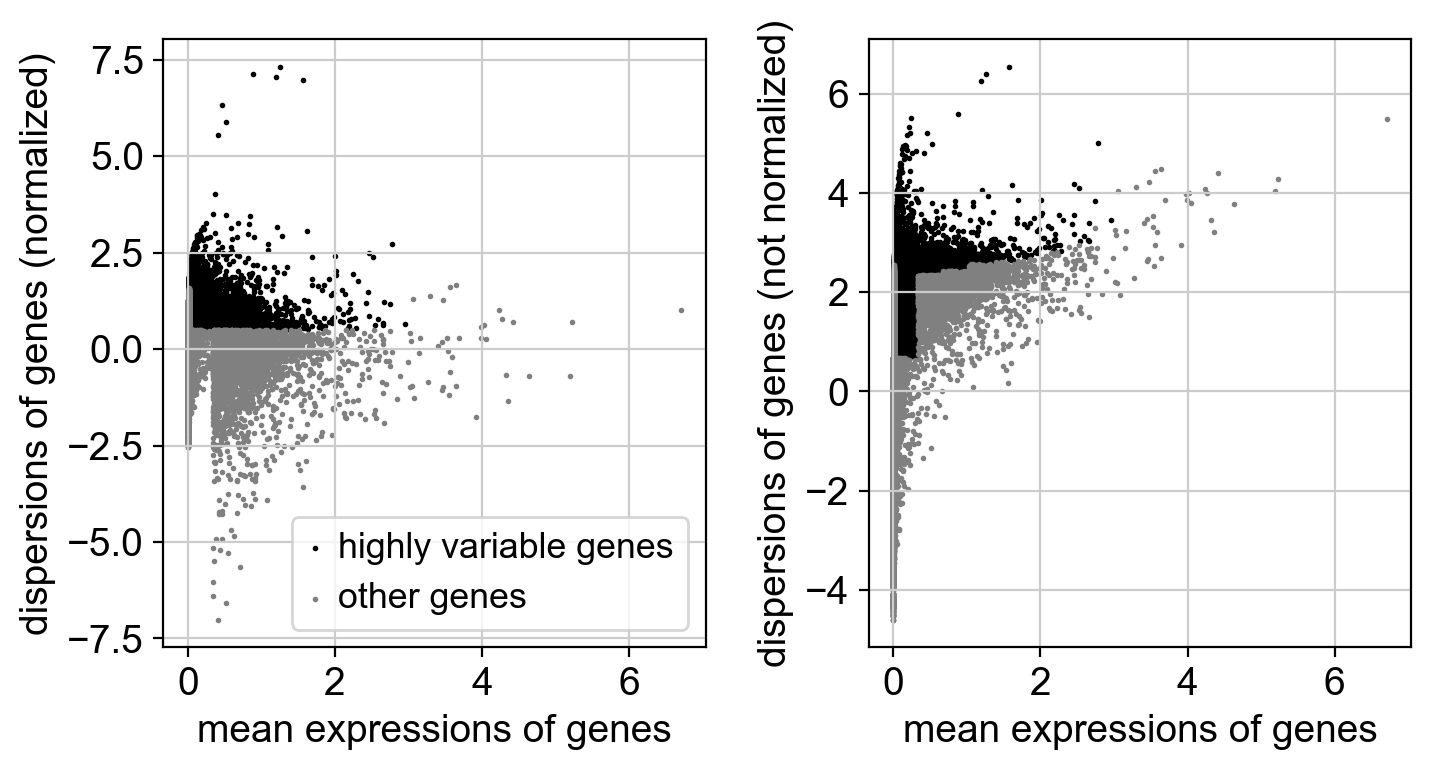

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
print("Highly variable genes: %d"%sum(adata.var.highly_variable))
sc.pl.highly_variable_genes(adata)

In [6]:
#adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'pct_counts_mt']
    finished (0:00:56)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


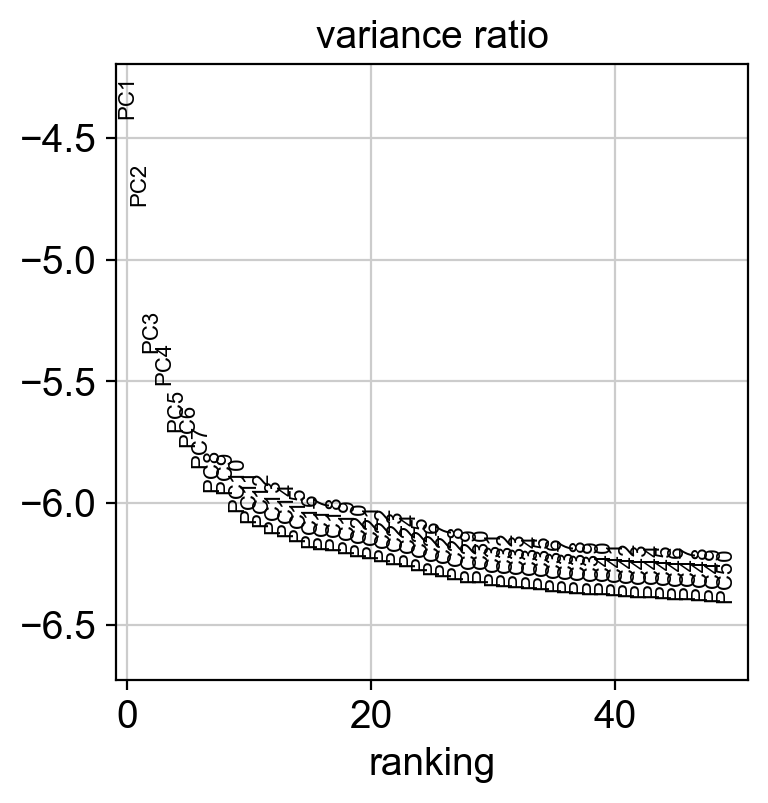

In [7]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True,n_pcs = 50)

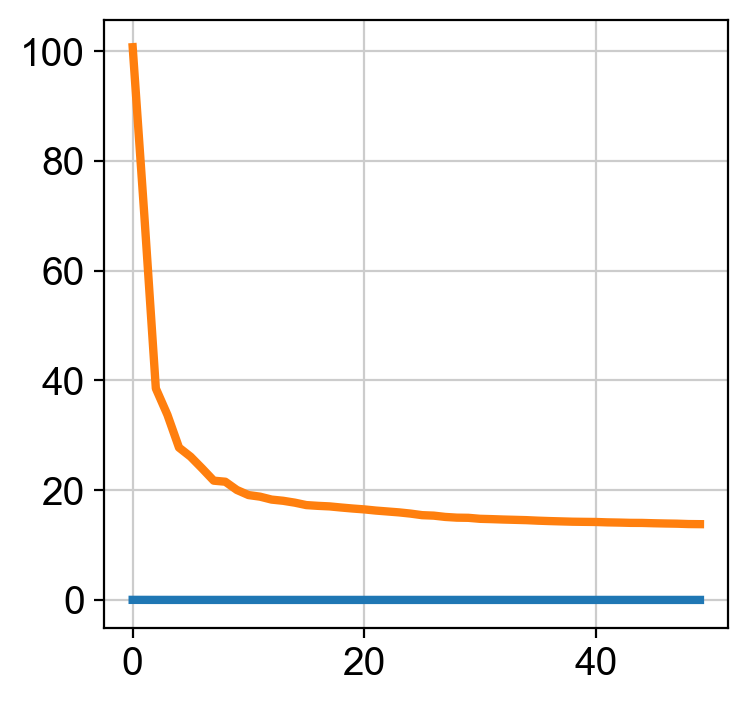

In [8]:
sns.lineplot(data = adata.uns['pca']['variance_ratio'],palette= 'tab10',linewidth = 3)
adata.uns['pca']['variance']
sns.lineplot(data =adata.uns['pca']['variance'],palette='tab10',linewidth = 3)
plt.savefig("./01.QC/PCA1.pdf",dpi=600)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
neighbors的数值为：10


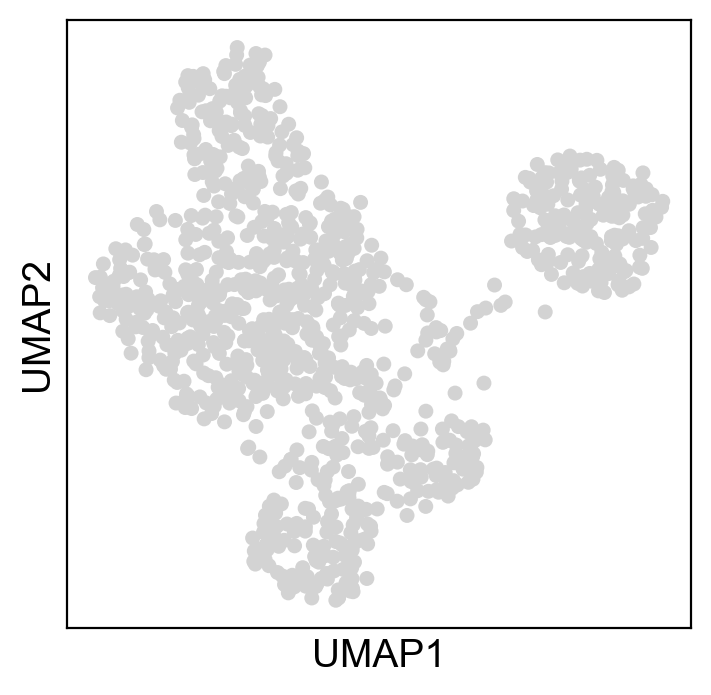

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：15


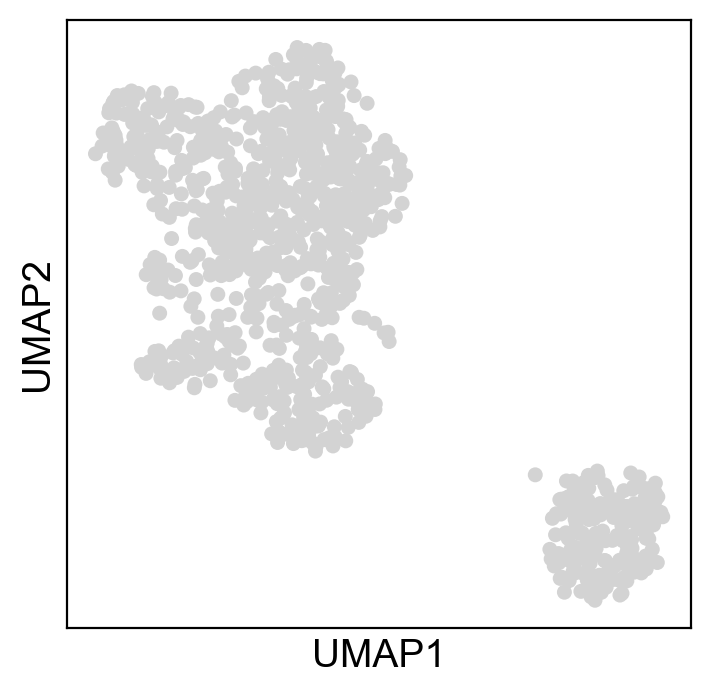

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
neighbors的数值为：20


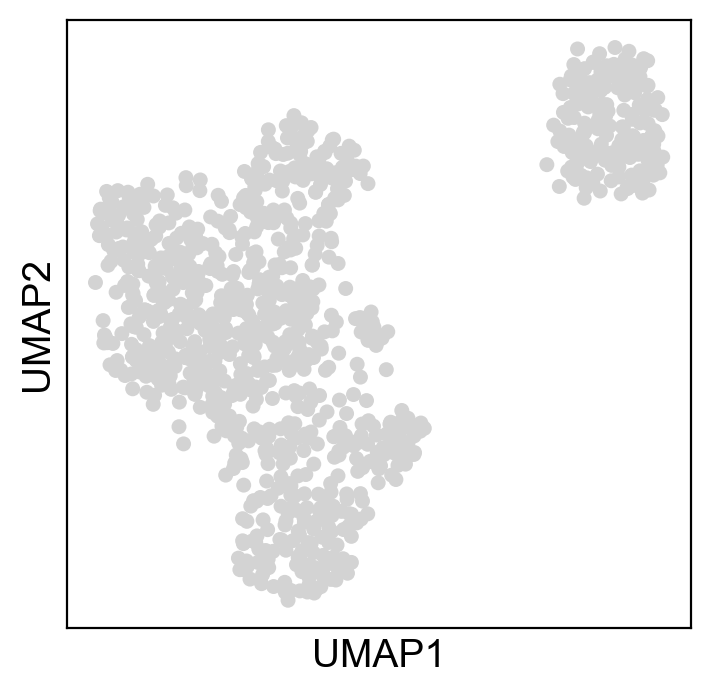

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)
neighbors的数值为：25


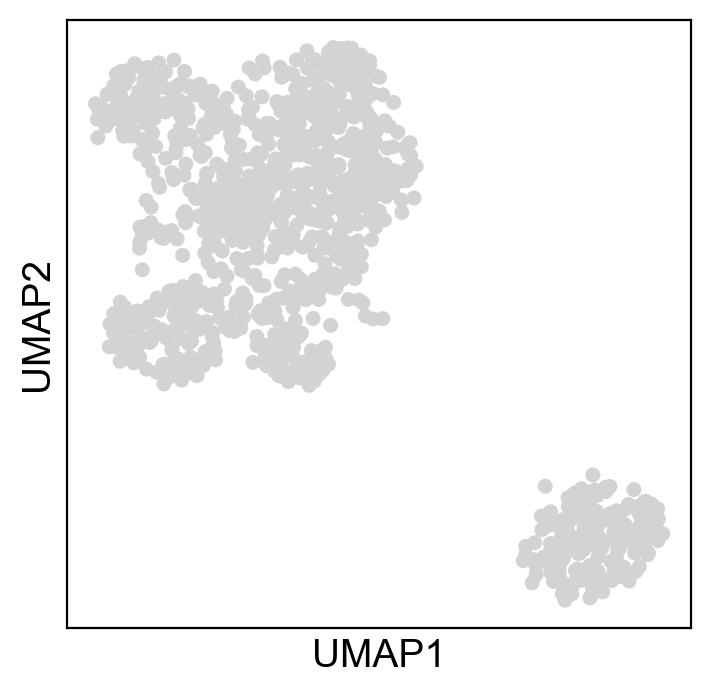

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：30


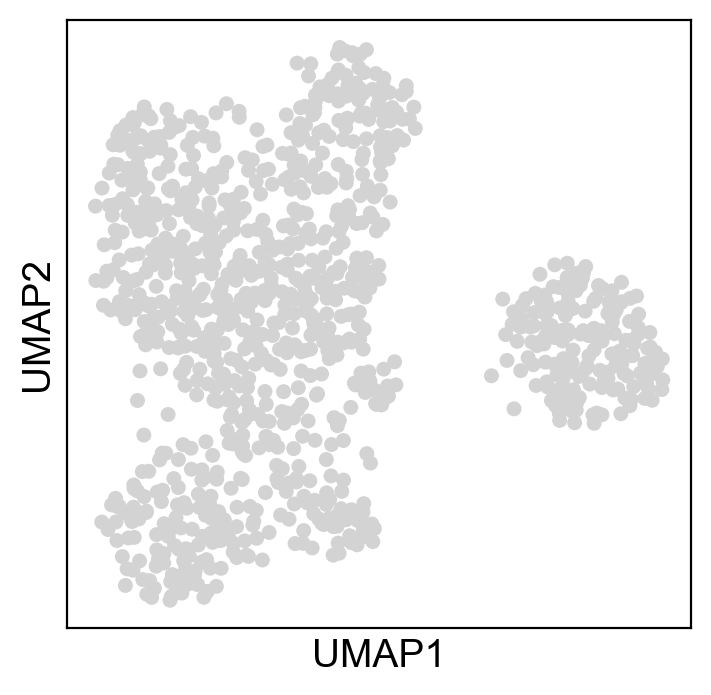

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：35


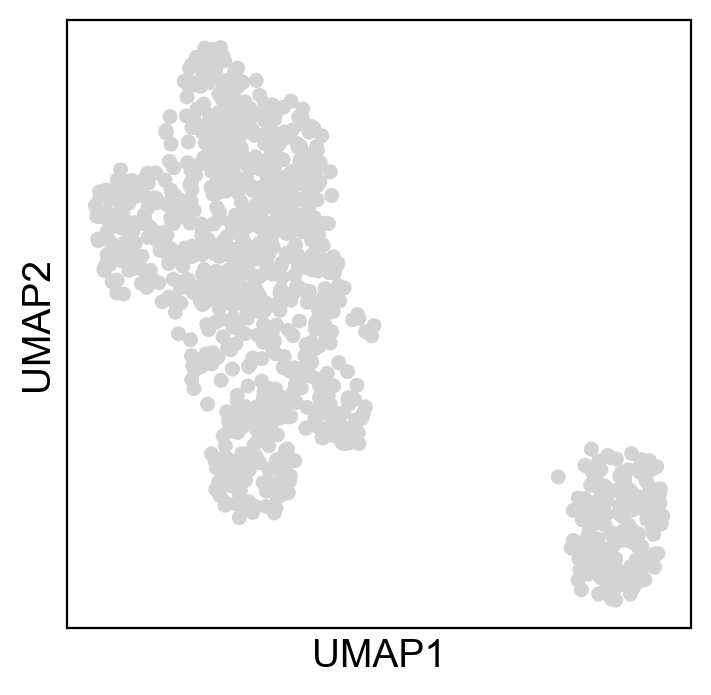

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：40


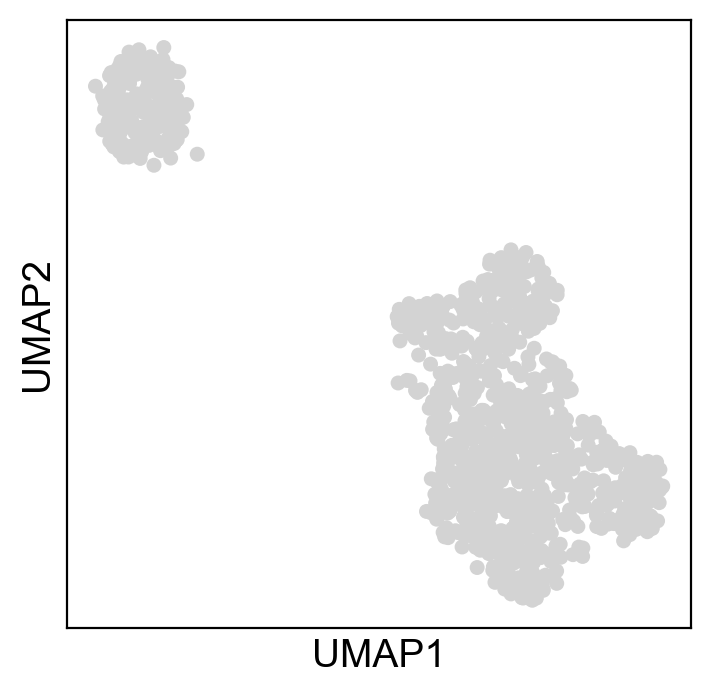

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：45


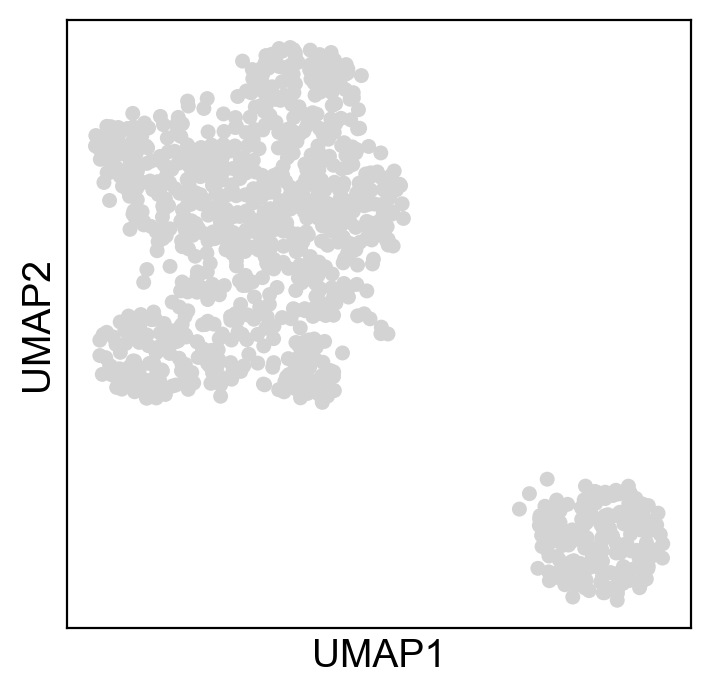

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：50


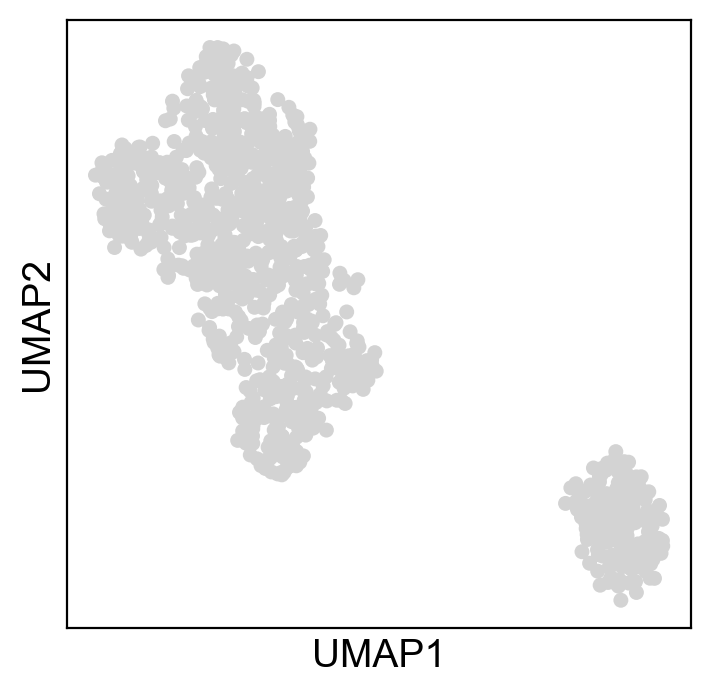

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
neighbors的数值为：55


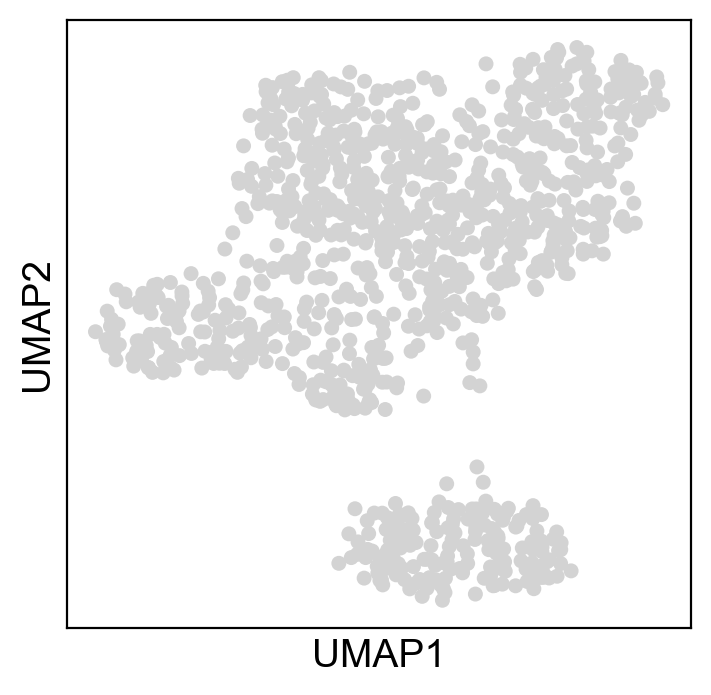

In [9]:
for i in range(10,60,5):
    sc.pp.neighbors(adata,n_pcs=30, n_neighbors= i)
    sc.tl.umap(adata)
    print(f'neighbors的数值为：{i}')
    sc.pl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


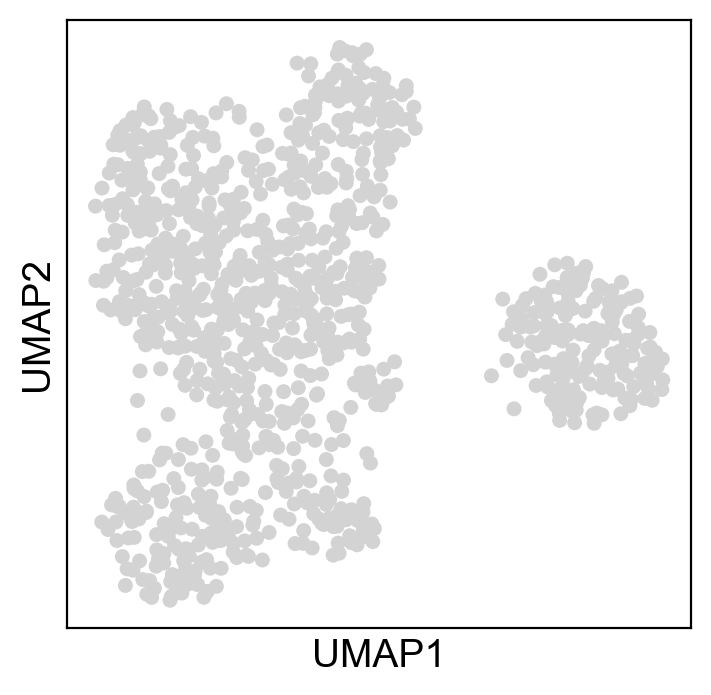

In [8]:
sc.pp.neighbors(adata,n_pcs=30, n_neighbors= 30)
sc.tl.umap(adata)
sc.pl.umap(adata)

In [9]:
for i in range(1,16):
    sc.tl.leiden(adata,resolution=round(i*0.1,1),key_added=f'cluster_{round(i*0.1,1)}')

running Leiden clustering
    finished: found 2 clusters and added
    'cluster_0.1', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 3 clusters and added
    'cluster_0.2', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'cluster_0.3', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 4 clusters and added
    'cluster_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 5 clusters and added
    'cluster_0.5', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'cluster_0.6', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 7 clusters and added
    'cluster_0.7', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clust

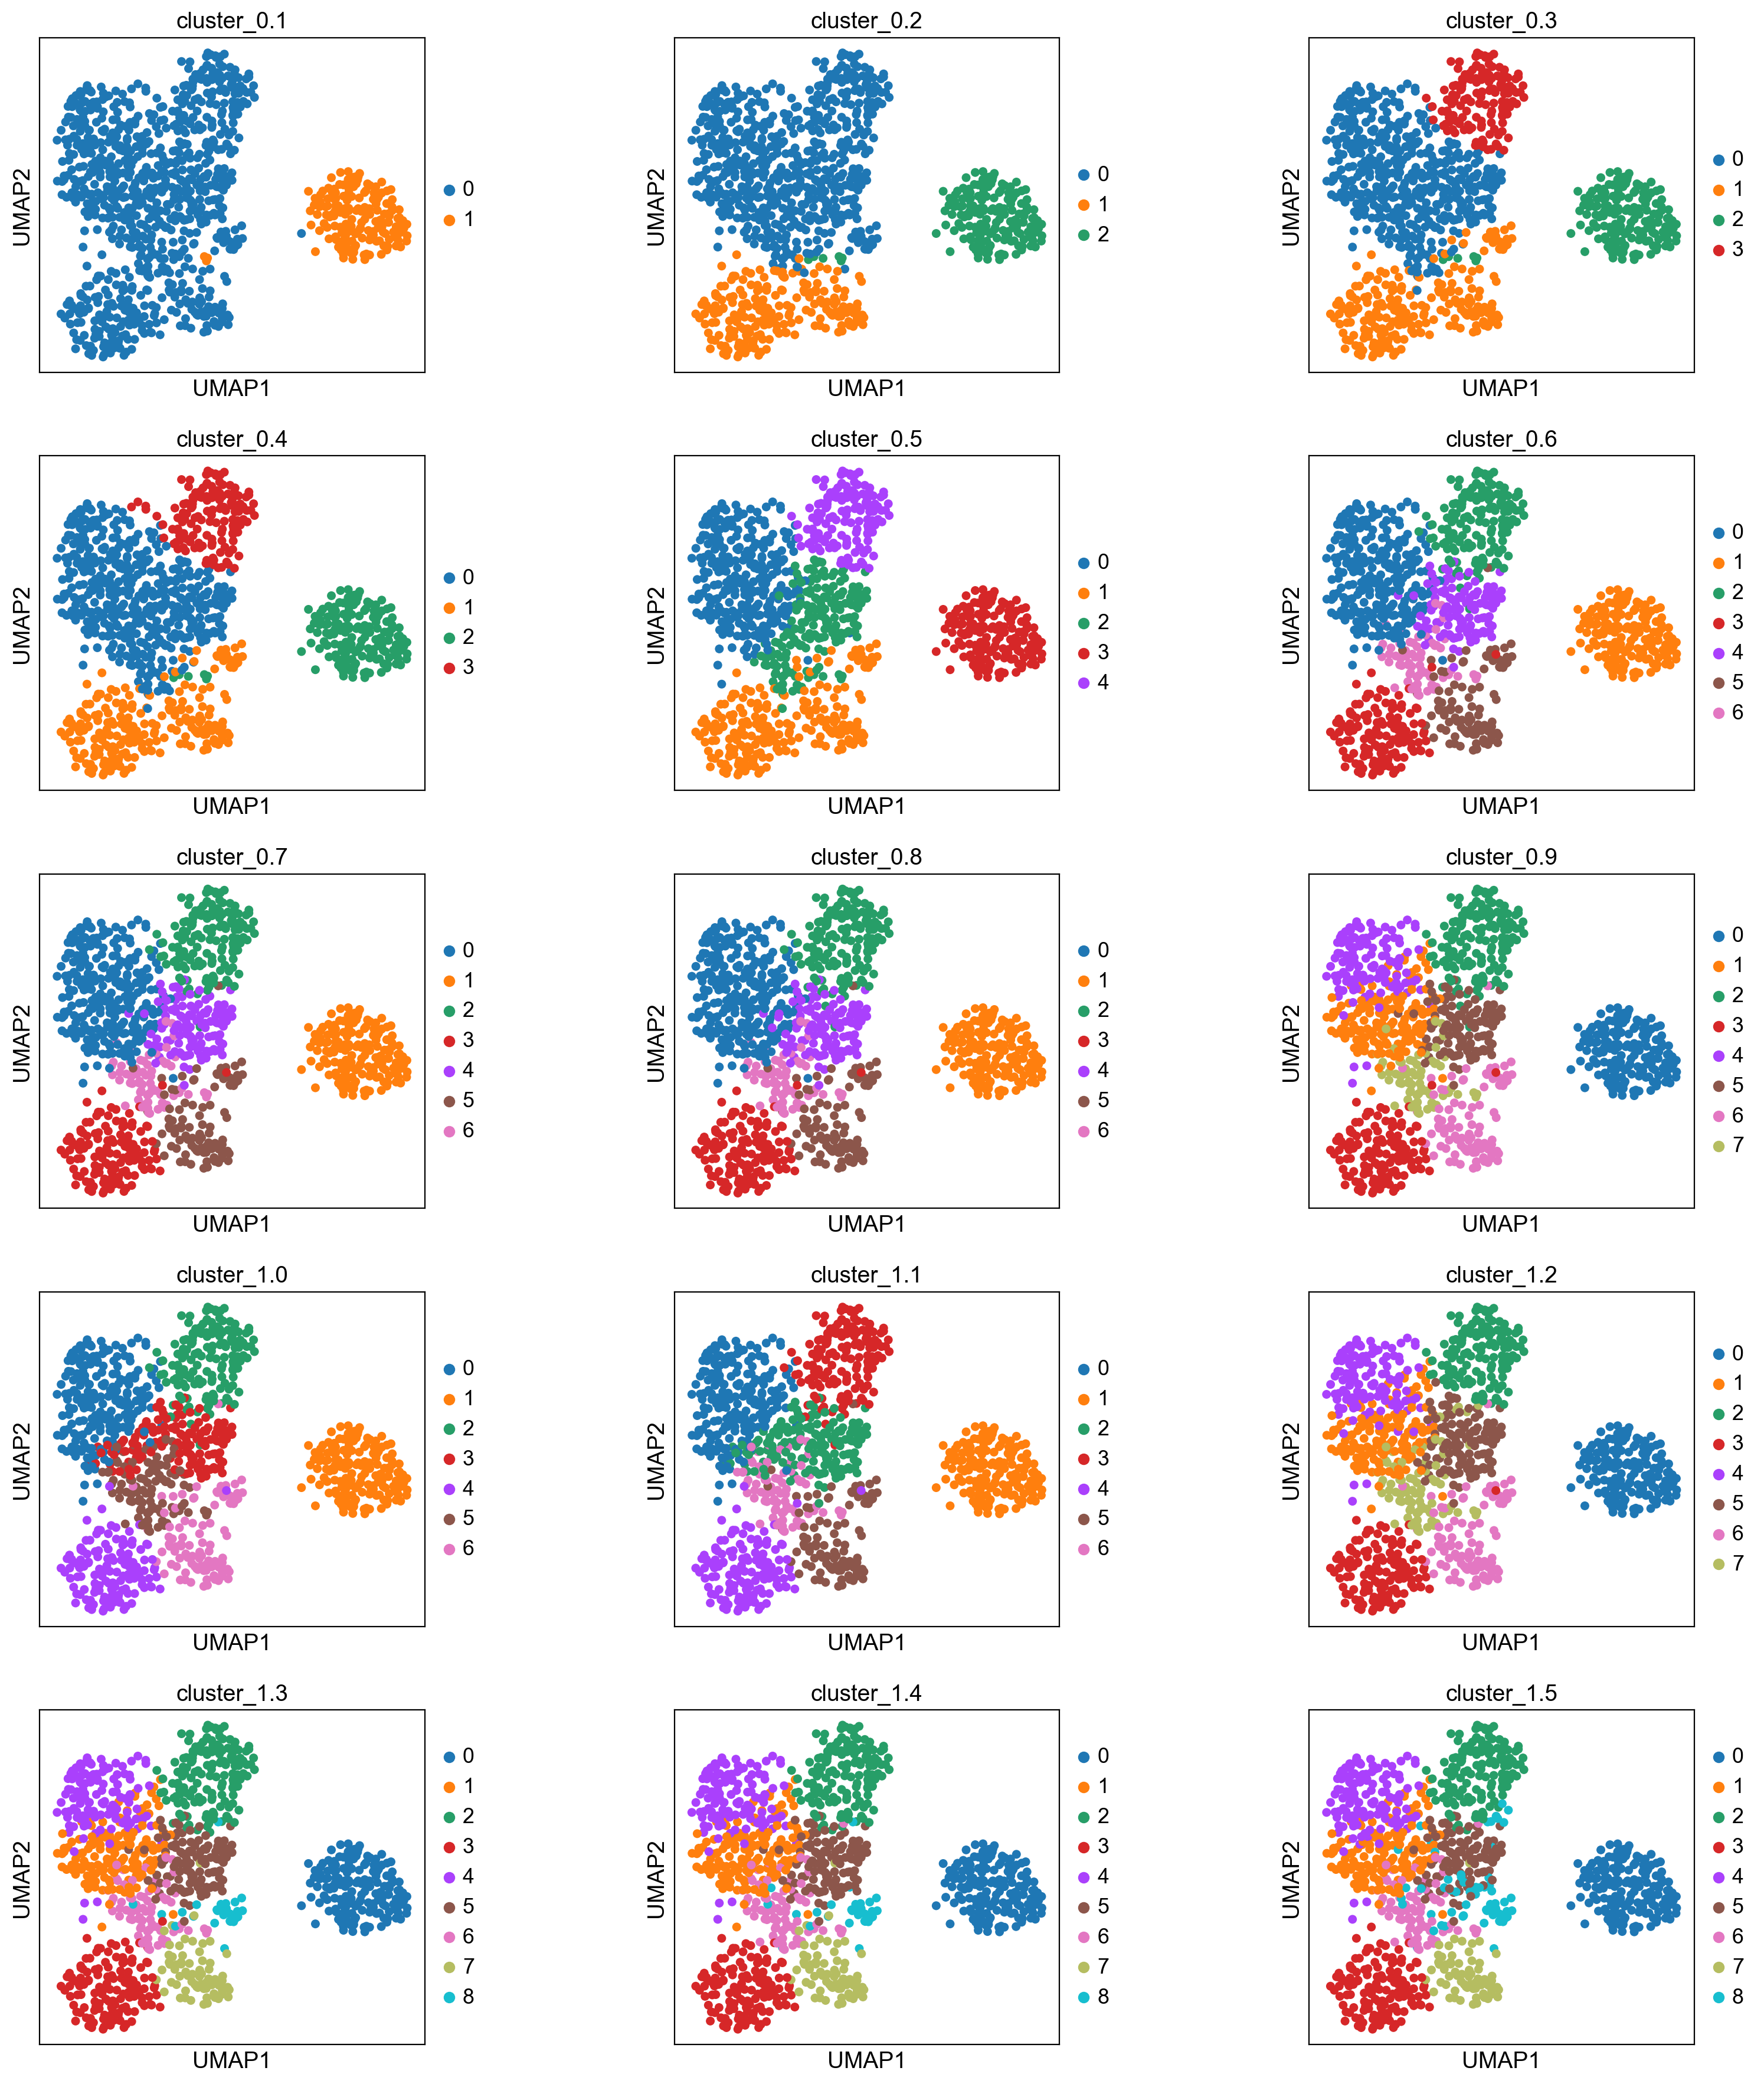

In [10]:
sc.pl.umap(adata,color = [f'cluster_{round(i*0.1,1)}' for i in range(1,16)],ncols = 3,wspace=0.5)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


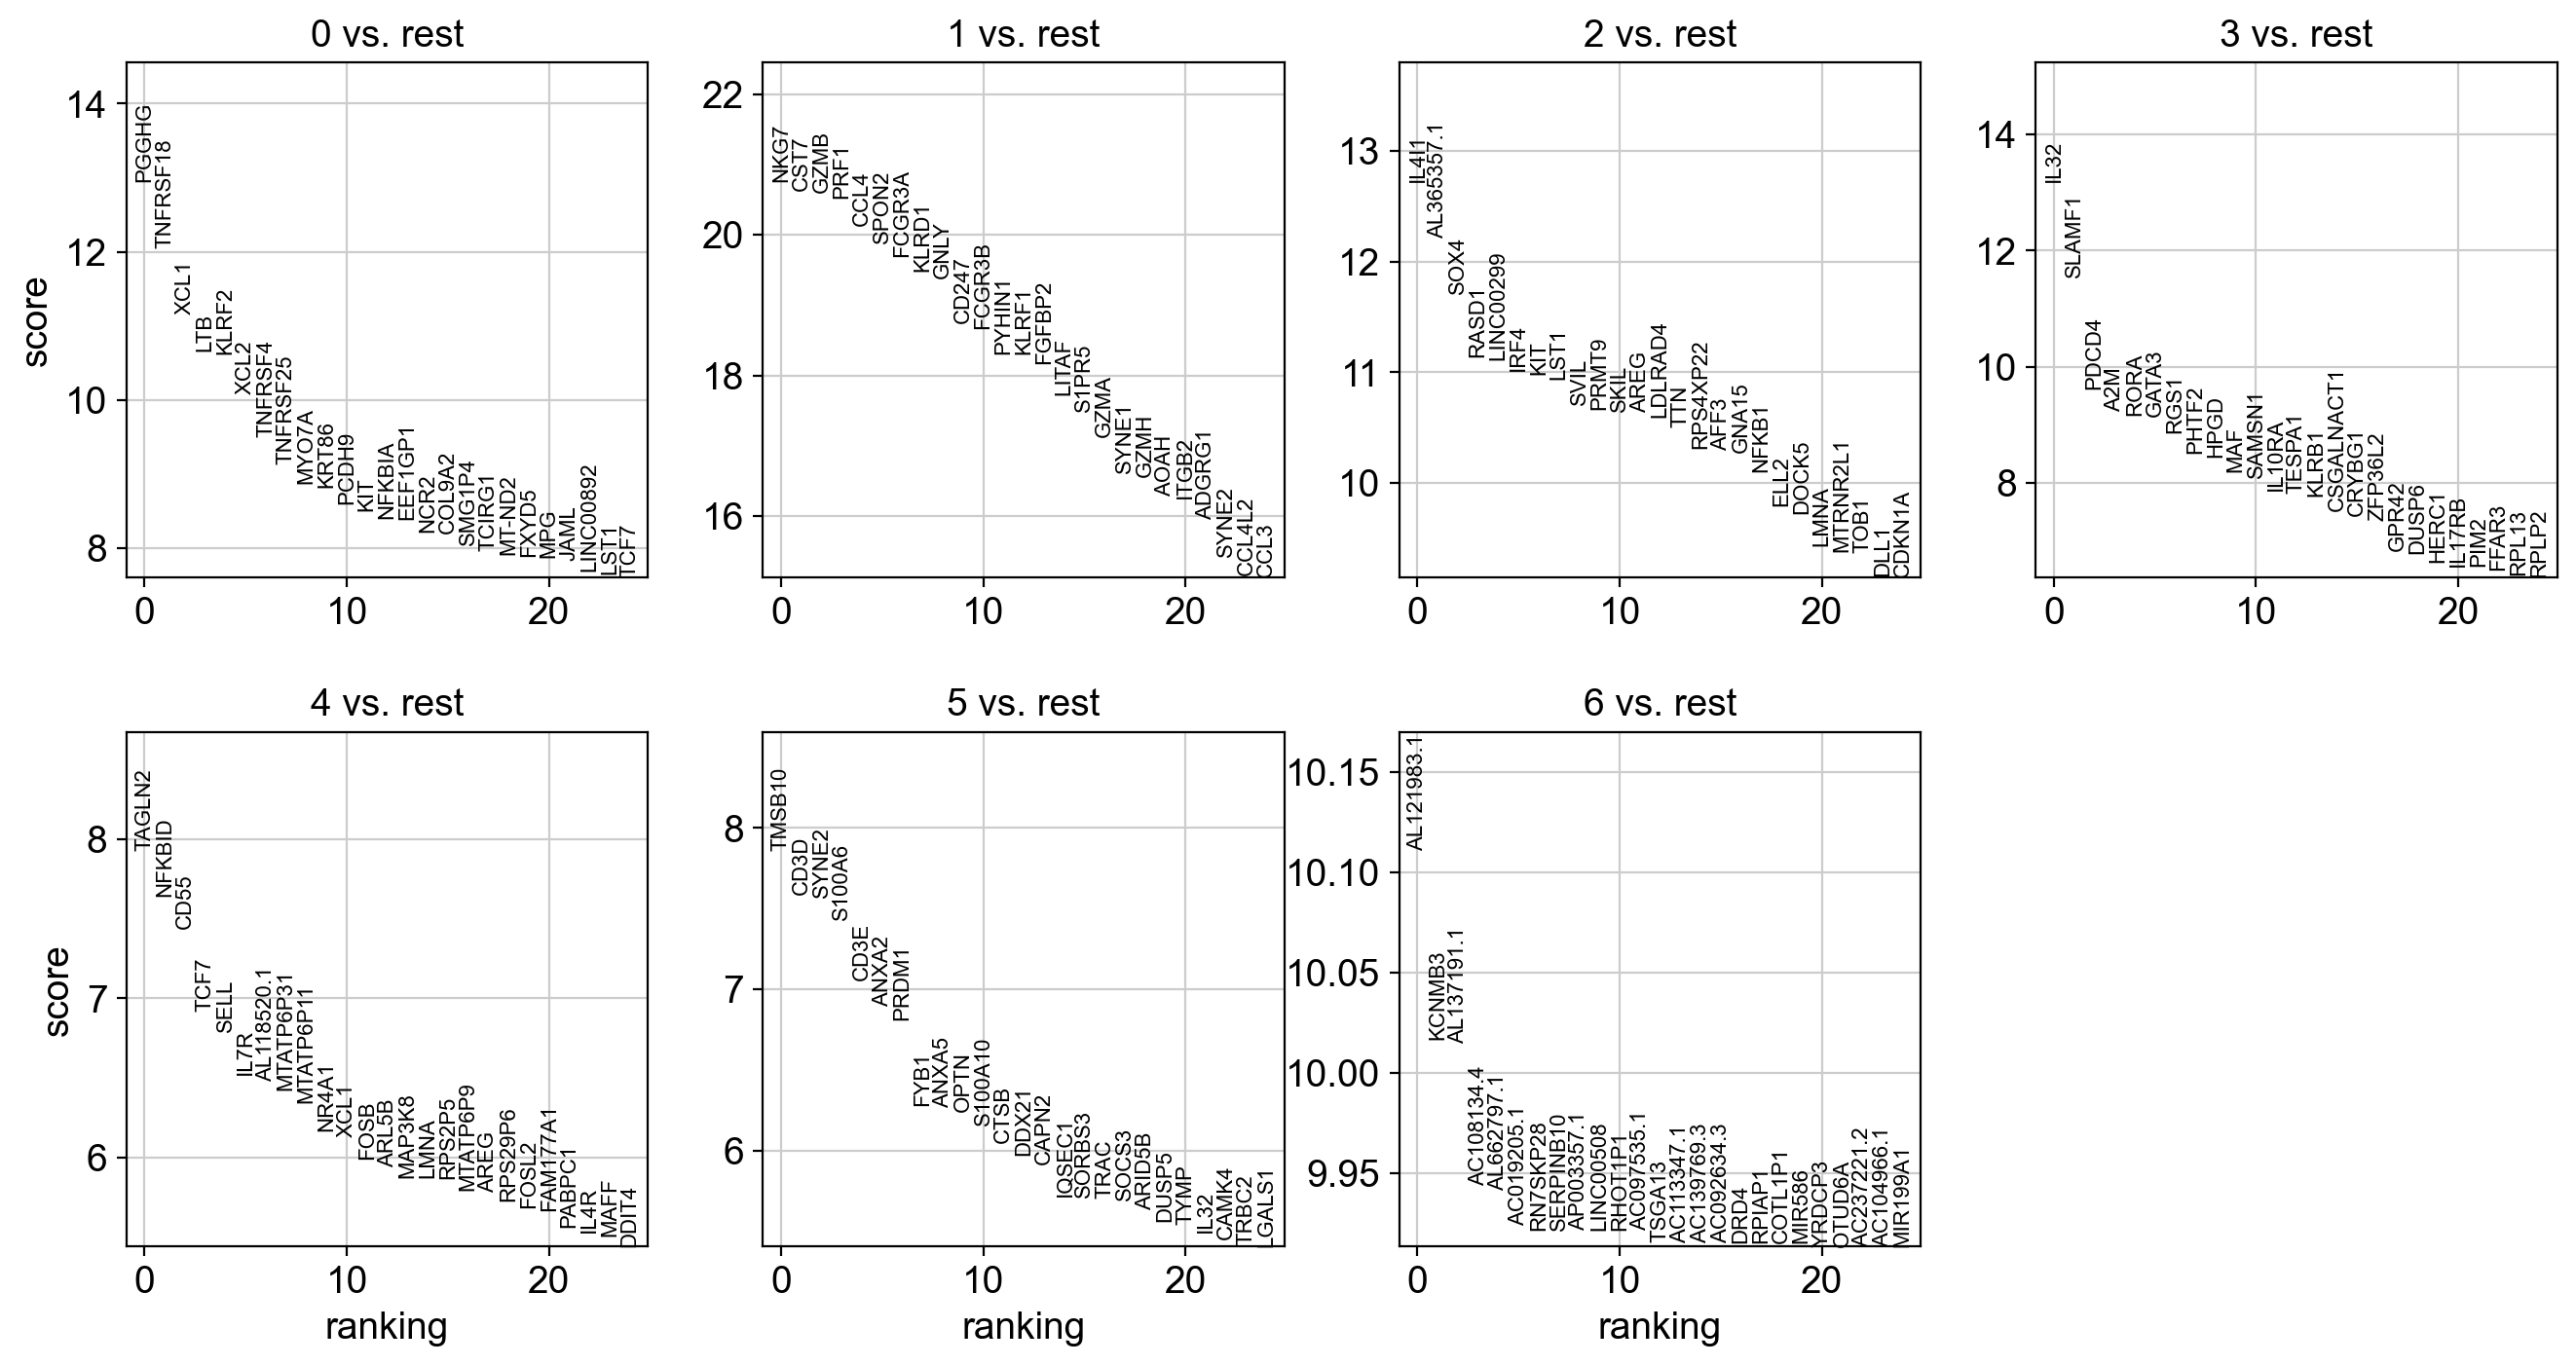

In [11]:
sc.tl.rank_genes_groups(adata,'cluster_0.6',method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [12]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(30)

0        1           2           3           4        5  \
0       PGGHG     NKG7       IL4I1        IL32      TAGLN2   TMSB10   
1    TNFRSF18     CST7  AL365357.1      SLAMF1      NFKBID     CD3D   
2        XCL1     GZMB        SOX4       PDCD4        CD55    SYNE2   
3         LTB     PRF1       RASD1         A2M        TCF7   S100A6   
4       KLRF2     CCL4   LINC00299        RORA        SELL     CD3E   
5        XCL2    SPON2        IRF4       GATA3        IL7R    ANXA2   
6     TNFRSF4   FCGR3A         KIT        RGS1  AL118520.1    PRDM1   
7    TNFRSF25    KLRD1        LST1       PHTF2   MTATP6P31     FYB1   
8       MYO7A     GNLY        SVIL        HPGD   MTATP6P11    ANXA5   
9       KRT86    CD247       PRMT9         MAF       NR4A1     OPTN   
10      PCDH9   FCGR3B        SKIL      SAMSN1        XCL1  S100A10   
11        KIT   PYHIN1        AREG      IL10RA        FOSB     CTSB   
12     NFKBIA    KLRF1     LDLRAD4      TESPA1       ARL5B    DDX21   
13    EEF1GP1   FGFBP2         TTN       KLRB1      MAP3K8    CAPN2   
14       NCR2    LITAF    RPS4XP22  CSGALNACT1        LMNA   IQSEC1   
15     COL9A2    S1PR5        AFF3      CRYBG1      RPS2P5   SORBS3   
16     SMG1P4     GZMA       GNA15     ZFP36L2    MTATP6P9     TRAC   
17     TCIRG1    SYNE1       NFKB1       GPR42        AREG    SOCS3   
18     MT-ND2     GZMH        ELL2       DUSP6     RPS29P6   ARID5B   
19      FXYD5     AOAH       DOCK5       HERC1       FOSL2    DUSP5   
20        MPG    ITGB2        LMNA      IL17RB    FAM177A1     TYMP   
21       JAML   ADGRG1    MTRNR2L1        PIM2      PABPC1     IL32   
22  LINC00892    SYNE2        TOB1       FFAR3        IL4R    CAMK4   
23       LST1   CCL4L2        DLL1       RPL13        MAFF    TRBC2   
24       TCF7     CCL3      CDKN1A       RPLP2       DDIT4   LGALS1   
25    LDLRAD3     CCL5        CD83      RPL18A    DNAJA1P3    COTL1   
26      MDFIC     PLEK        CYGB    C1orf162        JUND    IKZF3   
27      CPNE7     ZEB2       PDE4B     FAM129A    MTCO1P23   MRPL57   
28        LIF  KIR2DL3    ARHGAP10       NR3C1  AC008026.2     BATF   
29    SLC4A10    PLAC8    HLA-DQB1       RBMS1    MTND4LP3    MGST3   

             6  
0   AL121983.1  
1       KCNMB3  
2   AL137191.1  
3   AC108134.4  
4   AL662797.1  
5   AC019205.1  
6     RN7SKP28  
7    SERPINB10  
8   AP003357.1  
9    LINC00508  
10     RHOT1P1  
11  AC097535.1  
12      TSGA13  
13  AC113347.1  
14  AC139769.3  
15  AC092634.3  
16        DRD4  
17      RPIAP1  
18     COTL1P1  
19      MIR586  
20      YRDCP3  
21      OTUD6A  
22  AC237221.2  
23  AC104966.1  
24    MIR199A1  
25  AC004994.1  
26      RNASE4  
27     PDIA3P2  
28       IFNL3  
29       HTR1D

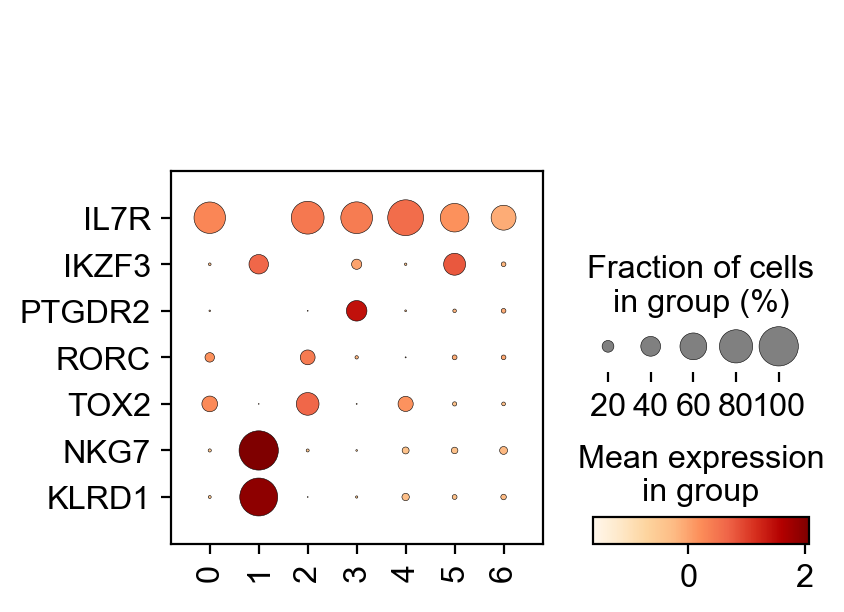

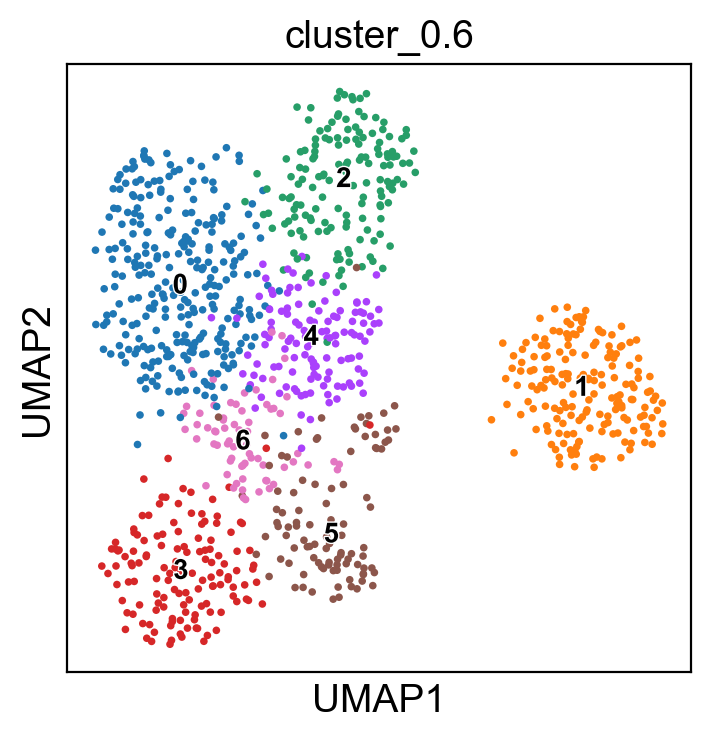

In [22]:
markers = [
        'IL7R',#ILC
        'IKZF3',
        'PTGDR2',#ILC2
        'RORC','TOX2',#ILC3
        "NKG7","KLRD1"
  
          ]
sc.pl.dotplot(adata,markers,'cluster_0.6',cmap='OrRd',swap_axes=True)
sc.pl.umap(adata, color=['cluster_0.6'], legend_loc='on data',size=30,
               legend_fontsize=10, legend_fontoutline= 1,wspace=0.5)

In [23]:
def annot_prelim(cluster):
    if cluster in ["0","2","4","6"]:
         return('ILC3')
    elif cluster in ['3']:
        return('ILC2')
    elif cluster in ['5']:
        return('ILC1')
    else:
        return('NK')

In [24]:
adata.obs['Celltype'] = adata.obs['cluster_0.6'].map(annot_prelim)

In [27]:
adata.obs["Celltype"] = adata.obs.Celltype.cat.set_categories([
      'ILC1','ILC2','ILC3','NK'
       ])
adata.obs["Celltype"] = adata.obs["Celltype"].astype('category')
adata.obs["Celltype"].cat.categories

Index(['ILC1', 'ILC2', 'ILC3', 'NK'], dtype='object')

In [43]:
new_colors = np.empty(len(adata.obs["Celltype"].cat.categories), dtype=object) 
new_colors[[0]] = '#FF6600' # ILC1
new_colors[[1]] = '#FF3300' # ILC2
new_colors[[2]] = '#FFCC00' # ILC3
new_colors[[3]] = '#0066CC' # NK
adata.uns["Celltype_colors"] = new_colors
new_colors

array(['#FF6600', '#FF3300', '#FFCC00', '#0066CC'], dtype=object)

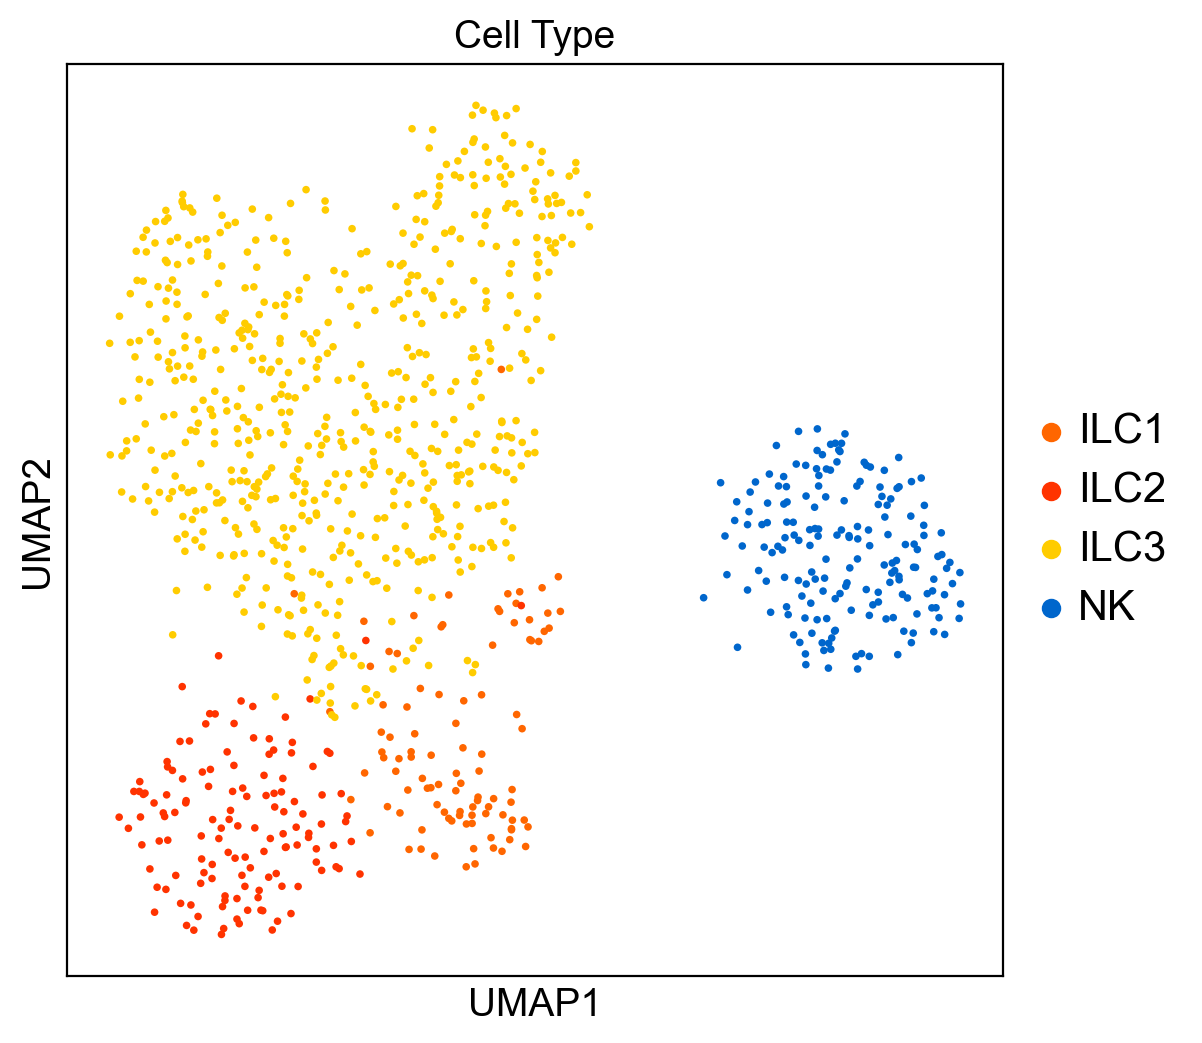

In [44]:
sc.settings.figdir = './step7-scRNA/'
sc.settings.set_figure_params(dpi=100,dpi_save=600,figsize=(6,6))
sc.pl.umap(adata, color='Celltype',size=30,title='Cell Type',
               legend_fontsize=15, legend_fontoutline= 2,frameon= True,save='celltype.pdf')

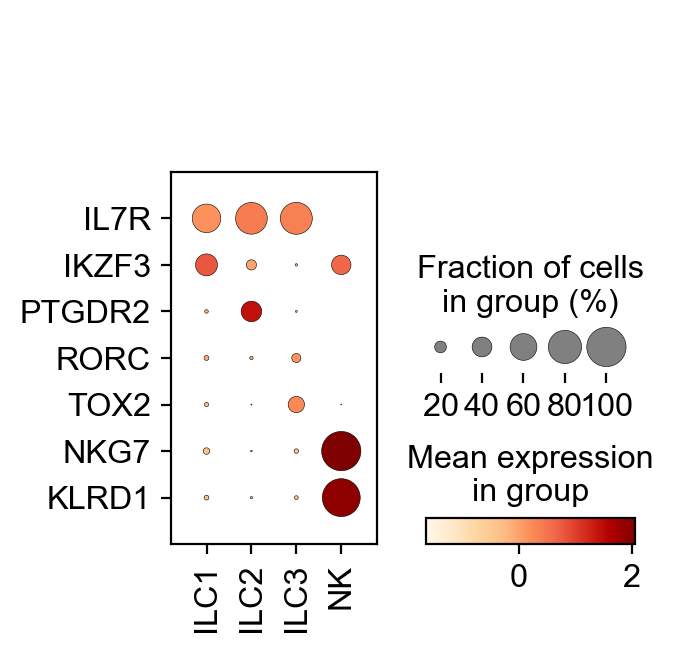

In [47]:
cluster = {
     "ILC1":['IL7R','STMN1','MKI67','IKZF3'],
     "ILC2":['GATA3','PTGDR2','MAF'],
     "ILC3":['RORC','TOX2'],
     "NK":['NKG7','KLRD1'],
 }
# marker_list = []

# for k,v in cluster.items():
#     if isinstance(v,list):
#         marker_list.extend(v)
#     else:
#         marker_list.append(v)
sc.settings.figdir = './step7-scRNA/'
sc.settings.set_figure_params(dpi=100,dpi_save=600,figsize=(6,6))
sc.pl.dotplot(adata,markers, 'Celltype',cmap='OrRd',swap_axes=True,save= 'DOTmarker2.pdf')

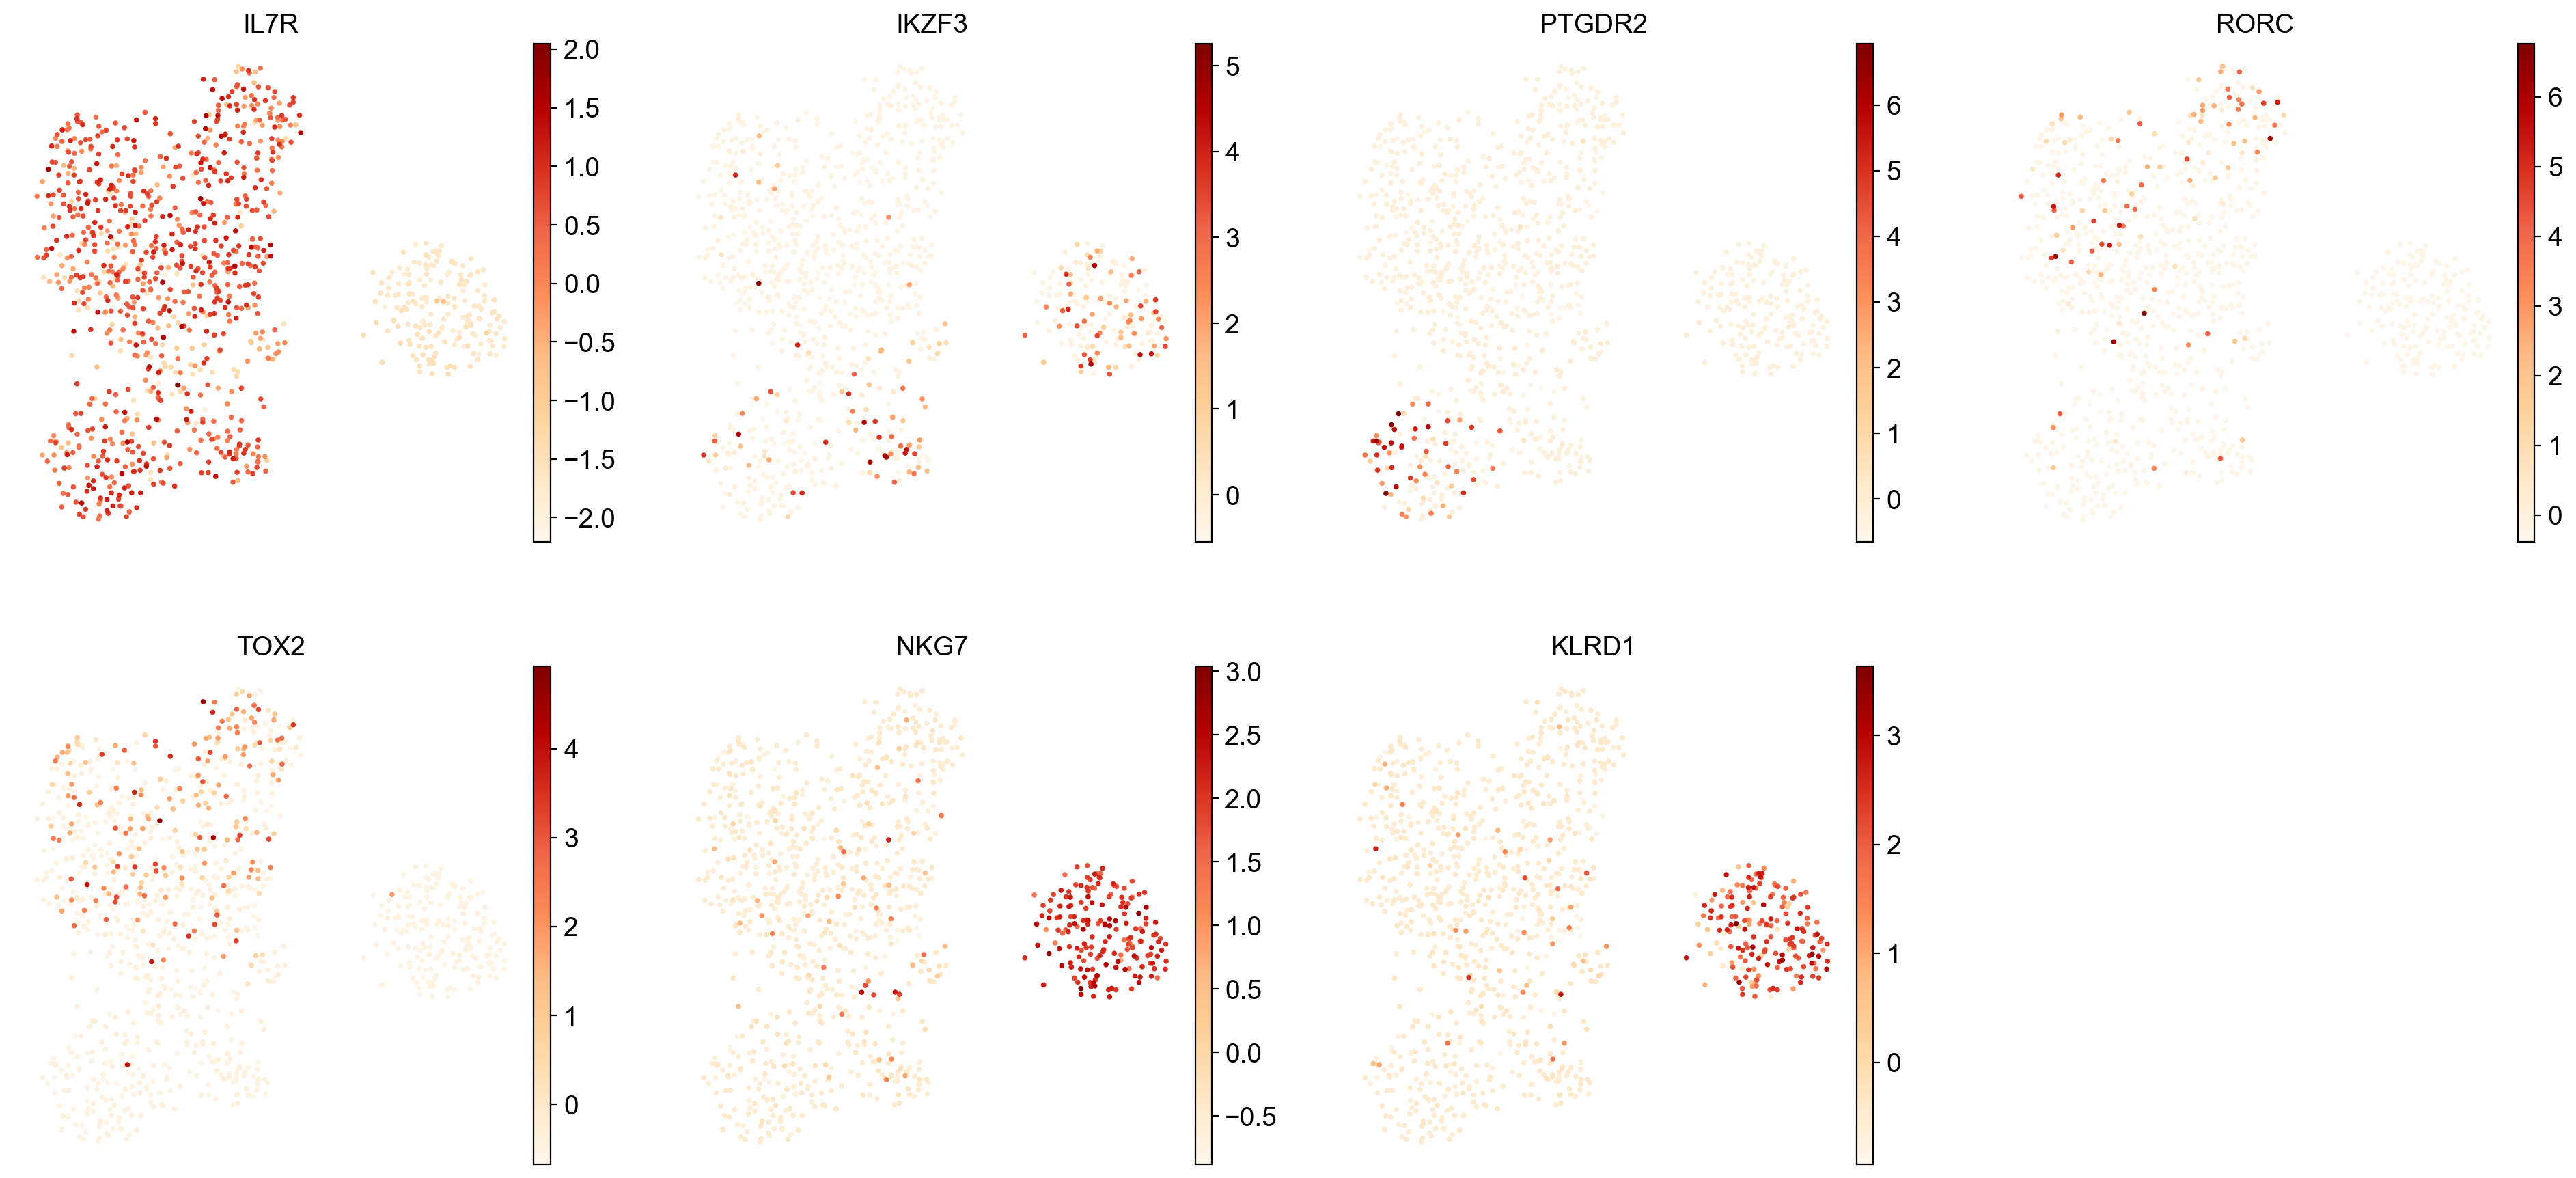

In [53]:
sc.settings.set_figure_params(dpi=100,dpi_save=600,figsize=(5,5))
genes = [g for g in markers if g in adata.var_names]
sc.pl.umap(adata, color = genes, legend_loc='on data', cmap='OrRd',frameon = False, s = 30)
#sc.pl.umap(adata,color=markers,ncols=4,cmap='OrRd',size=15,legend_fontsize=12,save='allmarker.pdf')

In [102]:
adata

AnnData object with n_obs × n_vars = 1035 × 50535
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_counts', 'log_counts', 'n_genes', 'cell.type', 'Donor', 'cluster_0.1', 'cluster_0.2', 'cluster_0.3', 'cluster_0.4', 'cluster_0.5', 'cluster_0.6', 'cluster_0.7', 'cluster_0.8', 'cluster_0.9', 'cluster_1.0', 'cluster_1.1', 'cluster_1.2', 'cluster_1.3', 'cluster_1.4', 'cluster_1.5', 'Celltype'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'cluster_0.1_colors', 'cluster_0.2_colors', 'cluster_0.3_colors', 'cluster_0.4_colors', 'cluster_0.5_colors', 'cluster_0.6_colors', 'cluster_0.7_colors', 'cluster_0.8_colors', 'cluster_0.9_colors', 'cluster_1.0_colors', 'cluster_1.1_colors', 'cluster_

computing density on 'umap'
--> added
    'umap_density_Donor', densities (adata.obs)
    'umap_density_Donor_params', parameter (adata.uns)


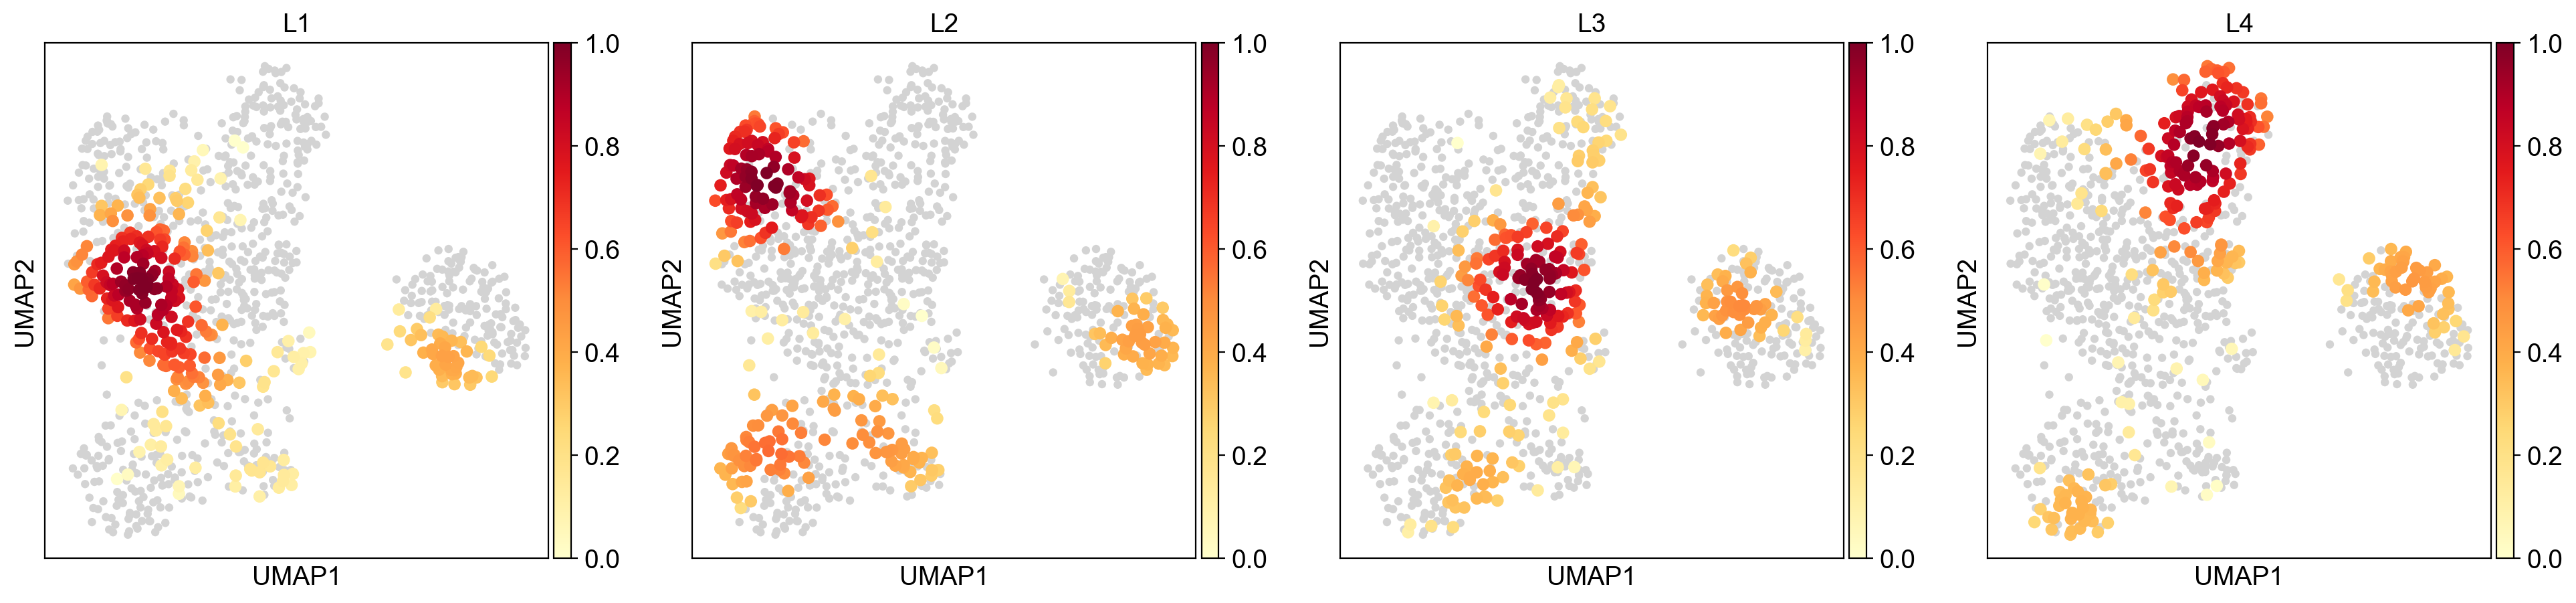

In [105]:
sc.tl.embedding_density(adata,groupby = 'Donor')
sc.pl.embedding_density(adata, key = 'umap_density_Donor',c)

computing density on 'umap'
--> added
    'umap_density_Celltype', densities (adata.obs)
    'umap_density_Celltype_params', parameter (adata.uns)


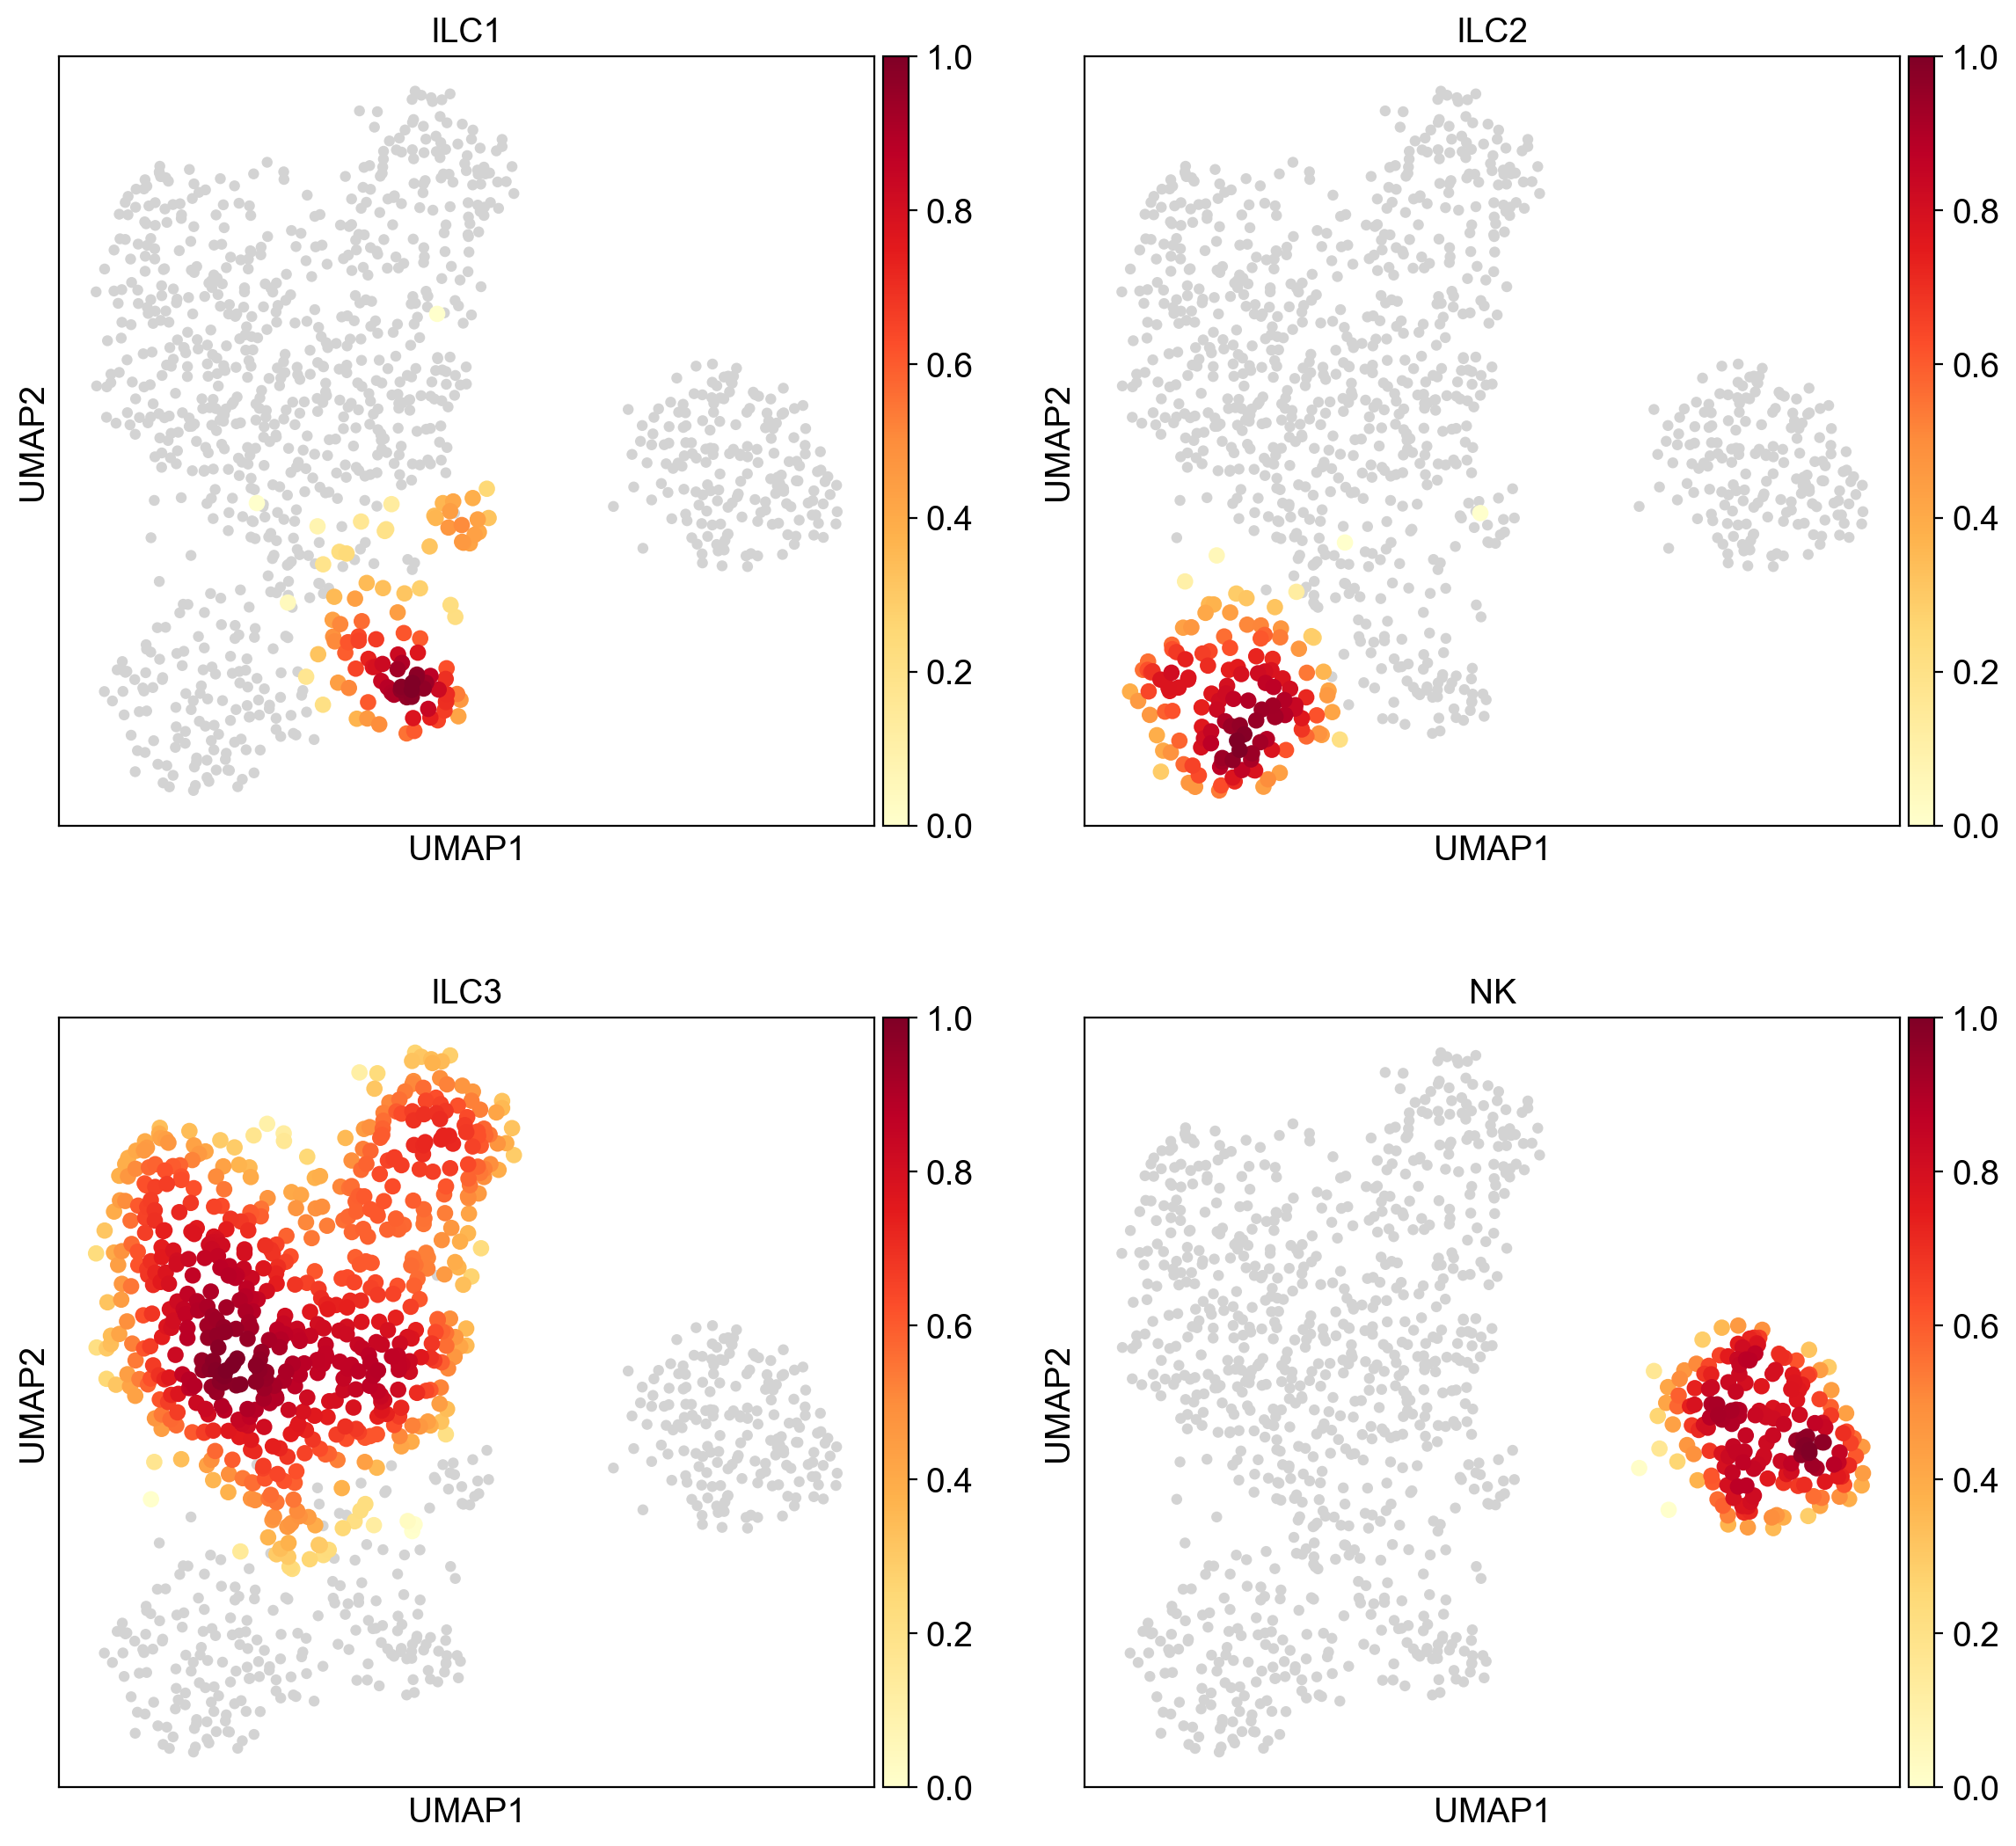

In [3]:
sc.settings.figdir = './step7-scRNA/'
sc.settings.set_figure_params(dpi=100,dpi_save=600,figsize=(6,6))
sc.tl.embedding_density(adata,groupby = 'Celltype')
sc.pl.embedding_density(adata, key = 'umap_density_Celltype',ncols=2,save='density.pdf')

In [65]:
cluster = {
     "ILC1":['IL7R','STMN1','MKI67','IKZF3'],
     "ILC2":['GATA3','PTGDR2','MAF'],
     "ILC3":['RORC','TOX2'],
     "NK":['NKG7','KLRD1'],
 }

[None, None]

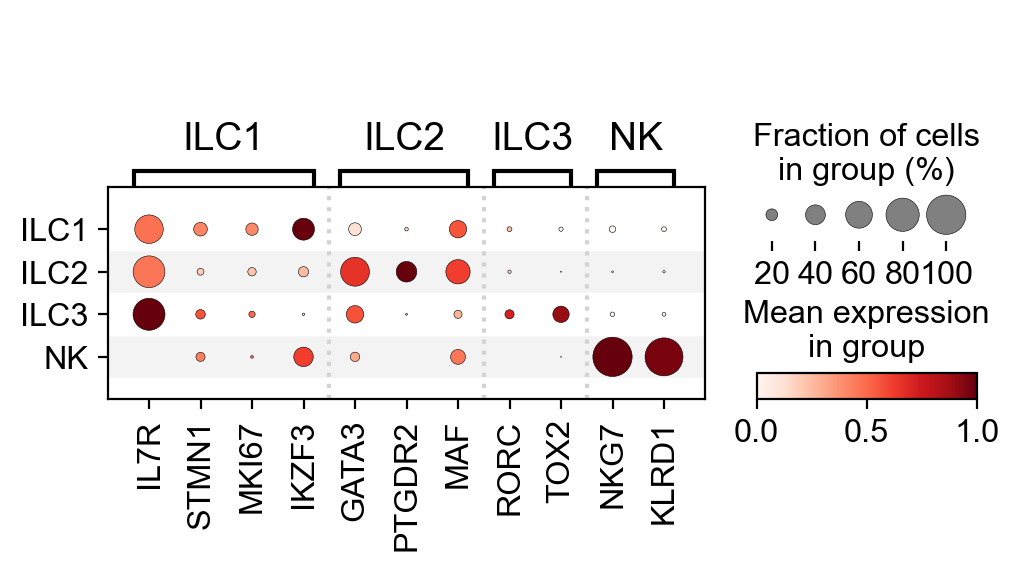

In [96]:
fig = sc.pl.dotplot(adata, groupby = 'Celltype', var_names = cluster, standard_scale = 'group', show = True, return_fig=True)

ax = fig.get_axes()
#cats = adata.uns['dendrogram_Celltype']['categories_ordered']
cats = ['ILC1', 'ILC2','ILC3','NK']
x = 0
for y, c in enumerate(cats):
    x+=len(cluster[c])
    if y != len(cats)-1:
        fig.ax_dict['mainplot_ax'].axvline(x, ls = ':', c = 'lightgray')
    if y%2==1:
        fig.ax_dict['mainplot_ax'].axhline(y+0.5, c = 'lightgray', zorder = -15, linewidth=15, alpha = 0.25) 
fig = plt.gcf()
[fig.savefig(os.path.join('./step7-scRNA/', f'Combined_All-cells_Dotplot_markers.{f}'), bbox_inches = 'tight') for f in ['pdf','png']]

In [108]:
adata.write_h5ad('./step7-scRNA/sc.h5ad')

In [4]:
adata.obs

n_genes_by_counts  total_counts  total_counts_mt  pct_counts_mt  \
A2_L1_P049                2435      270057.0          39190.0      14.511750   
A3_L1_P049                 535      102903.0           4517.0       4.389571   
A4_L1_P049                 495       83074.0           2775.0       3.340395   
A5_L1_P049                 769      154154.0           7935.0       5.147450   
A6_L1_P049                 708      110428.0          11488.0      10.403158   
...                        ...           ...              ...            ...   
P13_L4_P401                920       76541.0          23363.0      30.523508   
P14_L4_P401               2622      356660.0          36594.0      10.260192   
P15_L4_P401               3173      356350.0          51275.0      14.388943   
P21_L4_P401               2537      467461.0          43998.0       9.412122   
P22_L4_P401               2453      419922.0          36324.0       8.650178   

             total_counts_ribo  pct_counts_ribo  total_counts_hb  \
A2_L1_P049              2642.0         0.978312            939.0   
A3_L1_P049              1990.0         1.933860              1.0   
A4_L1_P049              1886.0         2.270265              8.0   
A5_L1_P049              3048.0         1.977243              0.0   
A6_L1_P049              1388.0         1.256928              0.0   
...                        ...              ...              ...   
P13_L4_P401             1337.0         1.746776              0.0   
P14_L4_P401            17782.0         4.985701              0.0   
P15_L4_P401             8076.0         2.266311              0.0   
P21_L4_P401             4895.0         1.047146              0.0   
P22_L4_P401             5419.0         1.290478              3.0   

             pct_counts_hb  n_counts  log_counts  ...  cluster_0.9  \
A2_L1_P049        0.347704  270057.0   12.506389  ...            6   
A3_L1_P049        0.000972  102903.0   11.541542  ...            7   
A4_L1_P049        0.009630   83074.0   11.327487  ...            7   
A5_L1_P049        0.000000  154154.0   11.945707  ...            7   
A6_L1_P049        0.000000  110428.0   11.612119  ...            7   
...                    ...       ...         ...  ...          ...   
P13_L4_P401       0.000000   76541.0   11.245582  ...            7   
P14_L4_P401       0.000000  356660.0   12.784538  ...            2   
P15_L4_P401       0.000000  356350.0   12.783669  ...            2   
P21_L4_P401       0.000000  467461.0   13.055071  ...            0   
P22_L4_P401       0.000714  419922.0   12.947824  ...            0   

            cluster_1.0 cluster_1.1 cluster_1.2 cluster_1.3 cluster_1.4  \
A2_L1_P049            6           5           6           8           8   
A3_L1_P049            5           6           7           6           6   
A4_L1_P049            5           6           7           6           6   
A5_L1_P049            5           6           7           6           6   
A6_L1_P049            5           6           7           6           6   
...                 ...         ...         ...         ...         ...   
P13_L4_P401           5           6           7           6           6   
P14_L4_P401           2           3           2           2           2   
P15_L4_P401           2           3           2           2           2   
P21_L4_P401           1           1           0           0           0   
P22_L4_P401           1           1           0           0           0   

            cluster_1.5 Celltype umap_density_Donor umap_density_Celltype  
A2_L1_P049            8     ILC1           0.107565              0.425595  
A3_L1_P049            6     ILC3           0.521077              0.448711  
A4_L1_P049            6     ILC3           0.557380              0.502297  
A5_L1_P049            6     ILC3           0.533881              0.479803  
A6_L1_P049            6     ILC3           0.602369              0.545381  
...                 ...      ...     

In [6]:
import diopy
adata.obs_names_make_unique()
diopy.output.write_h5(adata,file = './step7-scRNA/data.h5')